In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime

In [2]:
url = 'https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html'

### Extract date

In [3]:
content = requests.get(url).content
soup =BeautifulSoup(content, 'lxml')

In [4]:
data = soup.findAll(text=re.compile("Updated .+ 202\d"))
data

['Updated February 17, 2020']

In [5]:
m = re.search("Updated (\w+ \d+, 202\d)", data[0])
data_date_str = m.group(1)
data_date = datetime.strptime(data_date_str, '%B %d, %Y').strftime('%Y-%m-%d')
data_date

'2020-02-17'

### Extract data and add into Dataframe

In [6]:
dfs = pd.read_html(url)

In [7]:
if len(dfs) == 0 :
    raise Exception('There is no dataframes detected')

In [8]:
df = dfs[0]
df

,0,1
0,Positive,15
1,Negative,392
2,Pending§,60
3,Total,467


In [9]:
df = df.set_index(0).T
df

,Positive,Negative,Pending§,Total
1,15,392,60,467


In [10]:
# remove non alphanumeric characters from the columns
# also lowercase them
df.columns = df.columns.map(lambda x: re.sub('\W+', '', str.lower(x)))

# add column date to the front
df.insert(0, 'date', data_date)


In [11]:
df

,date,positive,negative,pending,total
1,2020-02-17,15,392,60,467


### Save to file

In [12]:
from pathlib import Path
csv_file = 'data/cdc-us-cases.csv'

if Path(csv_file).exists():
    # read out the old dat
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

In [13]:
df.sort_values(by=['date'], inplace=True)
df
df.to_csv(csv_file, index=False)

### Plot graph

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/cdc-us-cases.png'

# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

df.set_index('datetime_idx', inplace=True)
df

,date,positive,negative,pending,total
datetime_idx,,,,,
2020-01-31,2020-01-31,6,114,121,241
2020-02-03,2020-02-03,11,167,82,260
2020-02-05,2020-02-05,11,206,76,293
2020-02-07,2020-02-07,12,225,100,337
2020-02-10,2020-02-10,12,318,68,398
2020-02-12,2020-02-12,14,347,66,427
2020-02-14,2020-02-14,15,347,81,443
2020-02-17,2020-02-17,15,392,60,467


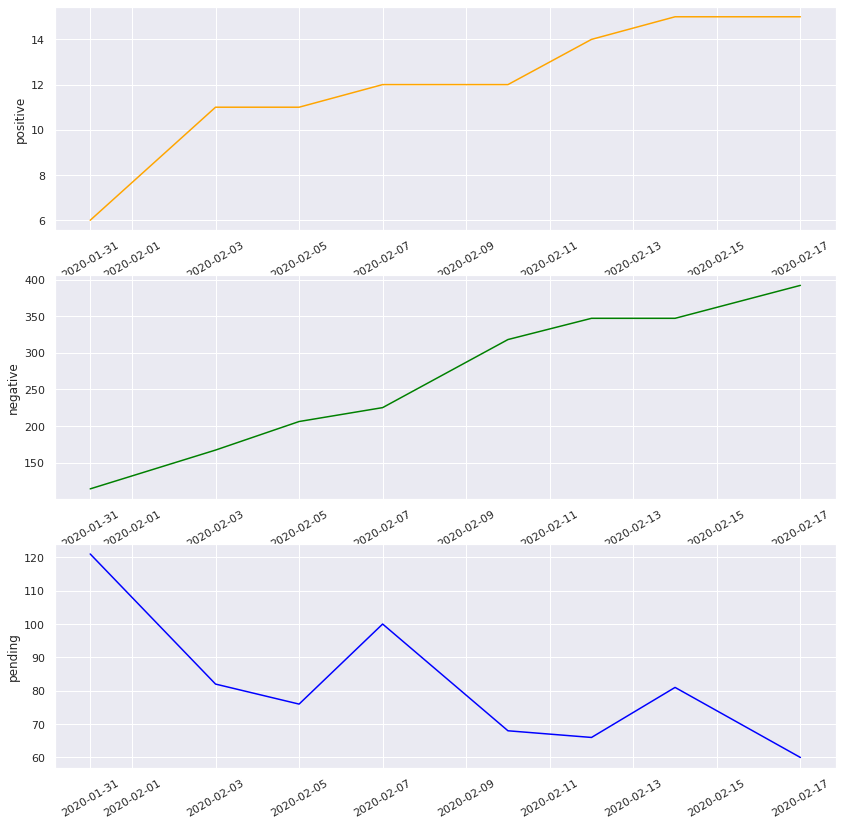

In [15]:
sns.set(rc={'figure.figsize':(14,14)})

fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df.index, y = 'positive', data=df, ax= axs[0], estimator=None, color='orange')
sns.lineplot(x=df.index, y = 'negative', data=df, ax= axs[1], estimator=None, color='green')
sns.lineplot(x=df.index, y = 'pending', data=df, ax= axs[2], estimator=None, color='blue')

for ax in axs:
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=30)



In [16]:
fig = ax.get_figure()
fig.savefig(png_file)